gen	nevals	avg     	min     	max   
0  	100   	-252.076	-447.346	17.115
1  	76    	-163.943	-367.537	101.908
2  	72    	-70.643 	-303.212	106.202
3  	67    	0.44141 	-163.582	112.504
4  	76    	40.7271 	-110.25 	112.504
5  	76    	50.9595 	-110.25 	112.504
6  	76    	54.4814 	-51.849 	112.504
7  	78    	60.873  	-103.21 	112.504
8  	77    	62.4489 	-57.802 	112.504
9  	78    	66.2087 	-47.28  	112.504
10 	83    	54.9621 	-32.207 	112.504
11 	69    	61.8704 	-32.207 	112.504
12 	87    	64.0381 	-32.207 	112.504
13 	77    	91.0597 	-32.207 	112.504
14 	81    	92.8496 	-16.768 	112.504
15 	80    	98.504  	-2.935  	112.504
16 	74    	110.004 	-32.207 	112.504
17 	77    	106.504 	-2.935  	112.504
18 	80    	106.504 	-2.935  	112.504
19 	82    	104.504 	-2.935  	112.504
20 	72    	110.504 	-2.935  	112.504
21 	86    	108.004 	-16.768 	112.504
22 	80    	106.504 	-2.935  	112.504
23 	79    	112.504 	112.504 	112.504
24 	80    	112.504 	112.504 	112.504
25 	81    	108.504 	-2.935  	112.504
Bes

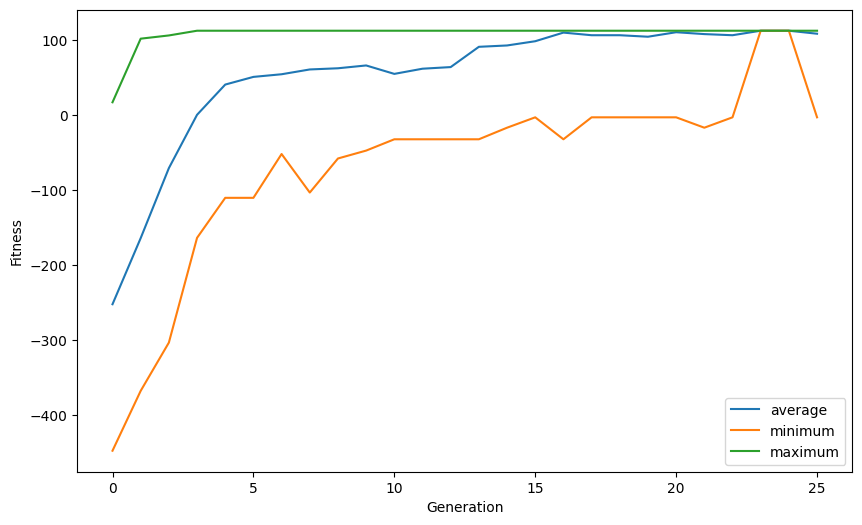

In [40]:
from deap import base, creator, tools, algorithms
import numpy
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

# Carga los datos del JSON
data = pd.read_json("../data.json")


def setup_deap():
    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMax)


setup_deap()

# Elecciones del Alumno
dias_libres = ["Lunes", "Viernes", "Sábado"]
preferencia_carga = "Practica"
cantidad_materias = 3

# Crea la caja de herramientas
toolbox = base.Toolbox()
toolbox.register("attr_materia", random.choice, data["Código"].tolist())
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attr_materia, n=cantidad_materias
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)





# Define la función de aptitud
def evaluar(individual):
    score = 0
    troncal_included = False

    # Crea un conjunto para cada día de la semana
    days = {day: set() for day in dias_libres}

    for code in individual:
        # Busca la materia en los datos cargados del JSON
        materia = data[data["Código"] == code]
        if not materia.empty:

            # Verifica si el día de la materia está en los días libres del estudiante
            for dia in materia["Día"].values[0]:
                if dia not in days or code in days[dia]:
                    # Si el día no está en los días libres, devuelve una aptitud muy baja
                    score -= 100
                else:
                    # Si no, añade la materia al conjunto de ese día
                    days[dia].add(code)

            # Verifica si el día de la materia está en los días libres del estudiante
            if any(dia in dias_libres for dia in materia["Día"].values[0]):
                score += 30

            # Aumenta el puntaje según la preferencia de carga del estudiante
            if preferencia_carga == "Practica":
                if materia["Practica"].values[0] == "alta":
                    score += 10
                if materia["Practica"].values[0] == "baja":
                    score -= 10
                if materia["Teoria"].values[0] == "alta":
                    score -= 5
            elif preferencia_carga == "Teoria":
                if materia["Teoria"].values[0] == "alta":
                    score += 10
                if materia["Teoria"].values[0] == "baja":
                    score -= 10
                if materia["Practica"].values[0] == "alta":
                    score -= 5

            # Aumenta el puntaje según el puntaje del profesor
            score += float(materia["Puntaje"].values[0].replace(",", ".")) / 10

            # Verifica si la materia es troncal
            if materia["Tipo"].values[0] == "Troncal":
                troncal_included = True

    # Penaliza si no se incluye una materia troncal
    if not troncal_included:
        score -= 50

    if not isValid(individual):
        score -=100  # return a very low score if the schedule is not valid

    return (score,)


toolbox.register("evaluate", evaluar)


# Define una función para obtener las materias seleccionadas de un individuo
def get_materias(individual):
    materias_seleccionadas = []
    for code in individual:
        materia = data[data["Código"] == code]
        if not materia.empty:
            materias_seleccionadas.append(materia.to_dict("records")[0])
    return materias_seleccionadas


def has_common_day(list1, list2):
    # Ensure list1 and list2 are lists
    if not isinstance(list1, list):
        list1 = [list1]
    if not isinstance(list2, list):
        list2 = [list2]
    
    # Convert the lists to sets
    set1 = set(list1)
    set2 = set(list2)
    
    # Return True if the intersection of the sets is not empty (i.e., the subjects overlap)
    return len(set1.intersection(set2)) > 0


def isValid(individual):
    # Initialize a dictionary to map each day to a list of subjects
    days = {day: [] for day in dias_libres}
    for subject_code in individual:
        # Convert the subject code to the corresponding subject dictionary
        subject = data[data["Código"] == subject_code].iloc[0].to_dict()
        # Ensure that subject["Día"] is a list
        if not isinstance(subject["Día"], list):
            subject["Día"] = [subject["Día"]]
        for day in subject["Día"]:
            # Check if the day is a free day
            if day not in dias_libres:
                return False
            # Check if there is already a subject scheduled for the day
            for existing_subject in days[day]:
                # Ensure that existing_subject["Día"] is a list
                if not isinstance(existing_subject["Día"], list):
                    existing_subject["Día"] = [existing_subject["Día"]]
                if existing_subject["Código"] != subject_code and has_common_day(existing_subject["Día"], subject["Día"]):
                    return False
            # Add the current subject to the day's list
            days[day].append(subject)
    return True


def mutUnique(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            swap_idx = random.randint(0, len(individual) - 1)
            while swap_idx == i:
                swap_idx = random.randint(0, len(individual) - 1)

            # Swap the subjects
            individual[i], individual[swap_idx] = individual[swap_idx], individual[i]

            # Check if the new combination is valid
            if not isValid(individual):
                # If the new combination is not valid, undo the swap
                individual[i], individual[swap_idx] = (
                    individual[swap_idx],
                    individual[i],
                )

            has_common_day(individual, individual[swap_idx])
    return (individual,)


def cxTwoPoint(ind1, ind2):
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = (
        ind2[cxpoint1:cxpoint2],
        ind1[cxpoint1:cxpoint2],
    )

    if not isValid(ind1) or not isValid(ind2):
        ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = (
            ind2[cxpoint1:cxpoint2],
            ind1[cxpoint1:cxpoint2],
        )

    return ind1, ind2


toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(data)-1, indpb=0.1)
toolbox.register("mutate", mutUnique, indpb=0.1)
# toolbox.register("mate", cxUnique)

toolbox.register("select", tools.selTournament, tournsize=3)


def main():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(
        pop,
        toolbox,
        cxpb=0.7,
        mutpb=0.3,
        ngen=25,
        stats=stats,
        halloffame=hof,
        verbose=True,
    )

    return pop, log, hof


if __name__ == "__main__":
    pop, log, hof = main()
    best_ind = hof[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    materias = get_materias(best_ind)
    print("Materias seleccionadas:")
    for materia in materias:
        print(materia)

    gen = log.select("gen")
    avg = log.select("avg")
    min_ = log.select("min")
    max_ = log.select("max")

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
   

    plt.show()
